In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from sklearn.datasets import make_blobs, make_classification
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(seed = 0)

In [3]:
class MakeData(object):
    """
    A class to generate
    Datasets
    
    """
    
    def __init__(self):
        
        return 
    
    
    def make_blobs(self, n_samples=100,
                            n_features=2, 
                            centers=None, 
                            cluster_std=1.0, 
                            center_box= (-10.0, 10.0),
                            shuffle=True, 
                            random_state=None, 
                            return_centers= True,
                            prior_centers  = None, 
                            mixture_number = 2, 
                            mixture_proportions = None, 
                            samples_per_mixture = None):
        
        
        """
        wrapper for make blobs in scikit learn
        see info there:
        'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.
        html#sklearn.datasets.make_blobs'
        prior_centers: array-like(n_centers, n_features)
                        generate gaussian mixtures with means
                        sampled from these prio centers
                        
        mixture_number: int, default 2
                        how many mixtures to generate
                        from each prior center
                        
        mixture_proportions" array-like(n_centers, mixture_number)
                            propabilities a point to be generated
                            from a gaussian from a specific mixture
                            the sum of each row should add up to 1
        samples_per_mixture: int, or array-like(mixture_number)
        
        
        """ 
        if prior_centers is not None:
            centers, n_samples = self.generate_mixtures(prior_centers,
                                                        mixture_number, mixture_proportions, 
                                                       samples_per_mixture,
                                                       n_features)
        
        parameters = {'n_samples':n_samples,
                      'n_features':n_features,
                      'centers': centers,
                      'cluster_std':cluster_std, 
                      'center_box':center_box,
                      'shuffle':shuffle, 
                      'random_state':random_state, 
                      'return_centers':return_centers}
        
        if return_centers:
            X,Y, centers = make_blobs(**parameters)
            return X, Y, centers
        else:
            X,Y = make_blobs(**parameters)
            return X,Y
            
            
    def generate_mixtures(self, prior_centers, mixture_number, 
                          mixture_proportions, samples_per_mixture, n_features):
        
        prior_centers = np.repeat(prior_centers, n_features, axis = 1)
        centers = np.zeros(shape = [len(prior_centers)*mixture_number, n_features])
        n_samples = np.zeros(len(centers))
        
        if mixture_proportions is None:
            mixture_proportions = np.ones(shape = [len(prior_centers), mixture_number])/mixture_number
            
        cov = np.eye(n_features)
            
        for i, center in enumerate(prior_centers):
            for j in range(mixture_number):
                centers[i*mixture_number + j] = np.random.multivariate_normal(center, cov)
                                    
                                    
        for i, s in enumerate(samples_per_mixture):
            ss = np.random.multinomial(s, pvals = mixture_proportions[i,:])
            for j in range(mixture_number):
                n_samples[i*mixture_number+j] = ss[j]
                
        return centers, n_samples.astype(int)
            
        
        
    def plot_data(self, X, Y, names = None):
        
        if X.shape[1] > 2:
            pca = PCA(n_components = 2)
            X = pca.fit_transform(X)
            
        clusters = np.unique(Y)  
        fig, ax = plt.subplots(1,1)
        
        for i in range((len(clusters))):
            
            xi = X[Y==i]
            ax.scatter(xi[:,0], xi[:,1], s = 0.1, label = '' if  names is None else names[i])
            if not names is None:
                ax.legend(loc = 'best',markerscale=10)
            
        
        plt.show()
        return fig, ax
    
    
    def assign_treatement(self, Y = None,  treated_size = 500, eligible_clusters = None,
                        eligible_proba = 0.99, non_eligible_proba = 0.05):
        
        """
        Y = nx1 array denoting the cluster numbers for each data point
        treated_size = Subjects in the study to be treated
        eligible_clusters = clusters of people eligible
        eligible_proba: P(T = 1 | E = 1)
        non_eligible_proba: 
        
        """
        
        
        if (Y is None) or (eligible_clusters is None):
            print('Give cluster ids and eligible clusters')
            
        eligible = np.zeros_like(Y)
        
        #denote eligible people with 1s
        mask = np.isin(Y, eligible_clusters)
        eligible[mask] = 1
        
        #Treatement assignments
        uniform_dist = np.random.uniform(0,1, len(Y))
        uniform_dist[mask] = uniform_dist[mask] <= eligible_proba
        uniform_dist[~mask] = uniform_dist[~mask] <= non_eligible_proba
        
        
        
        #Sample For treatment
        treatment_indexes = np.random.choice(np.where(uniform_dist == 1)[0], treated_size, replace = False)
        treatment = np.zeros_like(uniform_dist)
        treatment[treatment_indexes] = 1
        
        eligible = eligible.reshape([-1,1])
        treatment = treatment.reshape([-1,1])
        Y = Y.reshape([-1,1])
        
        df =  pd.DataFrame(np.concatenate([eligible, treatment, Y], axis = 1), columns = ['E', 'Tr', 'C'])
        df.Tr = df.Tr.astype(bool)
        return df
    
    def assign_constant_outcome(self, X, out_el_t = 1, out_el_nt = 0, out_nel_t = 1, out_nel_nt = 1, 
                               flip = 0.05):
        """
        X[E,T,C]: matrix with treatment eligibility, clusters
        
        """
        X['Y'] = 0
        
        X.loc[(X.Tr == 1)&(X.E == 1), 'Y'] = out_el_t
        X.loc[(X.Tr == 0)&(X.E == 1), 'Y'] = out_el_nt
        X.loc[(X.Tr == 1)&(X.E == 0), 'Y'] = out_nel_t
        X.loc[(X.Tr == 0)&(X.E == 0), 'Y'] = out_nel_nt
        X['Y1'] = 0
        X['Y0'] = 0
        X.loc[(X.Tr == 1)&(X.E == 1), 'Y1'] = out_el_t
        X.loc[(X.Tr == 0)&(X.E == 1), 'Y1'] = out_el_t
        X.loc[(X.Tr == 1)&(X.E == 0), 'Y1'] = out_nel_t
        X.loc[(X.Tr == 0)&(X.E == 0), 'Y1'] = out_nel_t
        
        X.loc[(X.Tr == 1)&(X.E == 1), 'Y0'] = out_el_nt
        X.loc[(X.Tr == 0)&(X.E == 1), 'Y0'] = out_el_nt
        X.loc[(X.Tr == 1)&(X.E == 0), 'Y0'] = out_nel_nt
        X.loc[(X.Tr == 0)&(X.E == 0), 'Y0'] = out_nel_nt
        
        #random flip of outcome
        uni = np.random.uniform(size = len(X)) <= flip
        
        X.loc[uni,'Y'] = 1-X.loc[uni,'Y']
        X.loc[X.Tr == 1, 'Y1'] = X.loc[X.Tr == 1, 'Y']
        X.loc[X.Tr == 0, 'Y0'] = X.loc[X.Tr == 0, 'Y']

        
        return X
    
    
    def printstats(self, X):
        print('Total Samples:', len(X))
        print('Total Eligible', (X.E == 1).sum())
        print('Total Non Eligible', (X.E == 0).sum())
        print('Total Eligible in Treatement', ((X.E == 1) & (X.Tr == 1)).sum())
        print('Total Non Eligible in Treatement', ((X.E == 0) & (X.Tr == 1)).sum())
        print('Total Eligible in Non Treatement', ((X.E == 1) & (X.Tr == 0)).sum())
        print('Total Non Eligible in Non Treatement', ((X.E == 0) & (X.Tr == 0)).sum())

              
        return
    
    @staticmethod
    def calculateEffects(X, out = True):
        ATE = (X.Y1 - X.Y0).mean()
        
        mask = X.Tr == 1
        ATT = (X[mask].Y1-X[mask].Y0).mean()
        
        maskE =  X.E == 1
        ATE_eligible = (X[maskE].Y1-X[maskE].Y0).mean()
        
        maskET =  (X.E == 1)& (X.Tr == 1)
        ATT_eligible = (X[maskET].Y1-X[maskET].Y0).mean()
        
        maskNE =  X.E == 0
        ATE_Neligible = (X[maskNE].Y1-X[maskNE].Y0).mean()
        
        maskNET =  (X.E == 0)& (X.Tr == 1)
        ATT_Neligible = (X[maskNET].Y1-X[maskNET].Y0).mean()
        
        if out:
            print('Real ATE:',ATE)
            print('Real ATT:',ATT)
            print('Real ATE Eligible:',ATE_eligible)
            print('Real ATT Eligible:',ATT_eligible)
            print('Real ATE Non Eligible:',ATE_Neligible)
            print('Real ATT Non Eligible:',ATT_Neligible)

        names = ['ate', 'att', 'ateE', 'attE', 'ateNE', 'attNE']
        metrics = [ATE, ATT, ATE_eligible, ATT_eligible, ATE_Neligible,
                  ATT_Neligible]
        
        true_effects = pd.Series(metrics, index = names)
        
        return true_effects




    
    
    def combine(self, X, D):
        
        X = pd.DataFrame(X, columns = ['x'+str(i) for i in range(X.shape[1])])
        
        F = pd.concat((X, D), axis = 1, ignore_index = False)
        return F



from sklearn.base import BaseEstimator, ClassifierMixin

class MLWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]
    
    
        
        
        
def log_effect(model, data, causes_names, w = None):
    
    m0 = model(random_state = 0, class_weight = w[0])
    mask0 = data.Tr == 0
    m0 = m0.fit(X = data.loc[mask0, causes_names].values,
                y = data[mask0].Y.values)
    
    mask1 = data.Tr == 1
    m1 = model(random_state = 0, class_weight = w[1])
    m1 = m1.fit(X = data.loc[mask1,causes_names].values,
                y = data[mask1].Y.values)
    
    return m0, m1

def ate(Y, Yest, Tr ):
    
    mask1 = Tr == 1
    ate = np.sum(Y[mask1] - Yest[mask1].Y0est)
    mask0 = Tr == 0
    ate = ate + np.sum(Yest[mask0].Y1est - Y[mask0])
    
    return ate/len(Y)

def att(Y, Yest, Tr):
    
    mask1 = Tr == 1
    K  = np.sum(mask1)
    att = np.sum(Y[mask1] - Yest[mask1].Y0est)
    
    return att/K
       
        
def causalModel(data = None, treatment_name = None, common_causes_names = None,
               outcome_name = None):
    
    data = data.copy()
    model = CausalModel(data = data, treatment = treatment_name,
                   common_causes = data_dict['common_causes_names'], outcome = data_dict['outcome_name'],
                   proceed_when_unidentifiable = True)
    
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    
    return model, identified_estimand , data      
        

In [4]:
mkd = MakeData()

In [5]:
%%time
mixture_number = 2
samples_per_mixture = [10000, 10000, 5000]
prior_centers = np.array([[-1],[-1], [1]])
n_features = 2
#centers = np.array([[0], [6], [9], [12]])

X,Y, centers = mkd.make_blobs(n_samples = 10000, n_features = n_features, centers = 5, return_centers=True,
                             prior_centers = prior_centers, samples_per_mixture = samples_per_mixture,
                             mixture_number = mixture_number)

CPU times: user 20.9 ms, sys: 7.58 ms, total: 28.5 ms
Wall time: 27.9 ms


In [6]:
D = mkd.assign_treatement(Y = Y, treated_size = 1500, eligible_clusters = np.array([4,5]))
D = mkd.assign_constant_outcome(D)
df = mkd.combine(X, D)
mkd.printstats(df)
true_effects = mkd.calculateEffects(df)

Total Samples: 25000
Total Eligible 5000
Total Non Eligible 20000
Total Eligible in Treatement 1238
Total Non Eligible in Treatement 262
Total Eligible in Non Treatement 3762
Total Non Eligible in Non Treatement 19738
Real ATE: 0.22964
Real ATT: 0.7813333333333333
Real ATE Eligible: 0.9566
Real ATT Eligible: 0.9547657512116317
Real ATE Non Eligible: 0.0479
Real ATT Non Eligible: -0.03816793893129771


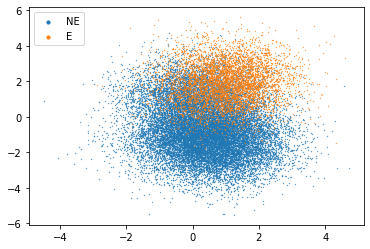

In [7]:
fig, ax = mkd.plot_data(X, D.E, ['NE', 'E'])
plt.show()

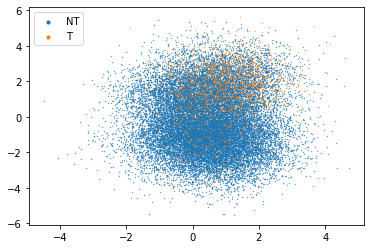

In [8]:
fig, ax = mkd.plot_data(X, D.Tr, ['NT', 'T'])
plt.show()

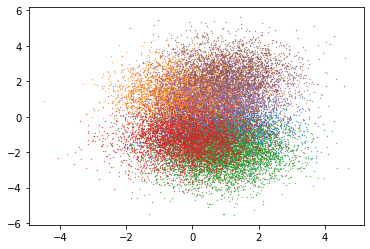

In [9]:
fig, ax = mkd.plot_data(X, Y)
plt.show()

### At this point we have created our synthetic dataset

In [10]:
df.head()

,x0,x1,E,Tr,C,Y,Y1,Y0
0,0.283653,2.171540,1.0,True,5.0,0,0,0
1,0.157970,-1.494734,0.0,False,2.0,1,1,1
2,-0.399029,0.175196,0.0,False,3.0,1,1,1
3,2.673653,2.692547,1.0,False,5.0,0,1,0
4,1.079026,-1.416046,0.0,False,2.0,1,1,1


In [11]:
mkd.printstats(df.loc[:,'E':])

Total Samples: 25000
Total Eligible 5000
Total Non Eligible 20000
Total Eligible in Treatement 1238
Total Non Eligible in Treatement 262
Total Eligible in Non Treatement 3762
Total Non Eligible in Non Treatement 19738


In [12]:
import dowhy
from dowhy import CausalModel

### Supresse unnecessary log messages and warnings

In [13]:
import logging
logging.getLogger("dowhy").setLevel(logging.WARNING)

import warnings

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
#warnings.warn = warn


### Make causal model

In [14]:
common_causes_names = ['x'+str(i) for i in range(n_features)]
outcome_name = 'Y'
data_dict = {'data':df,
             'treatment_name': 'Tr',
             'outcome_name': 'Y',
             'common_causes_names': common_causes_names
            }
             

### Dowhy Models

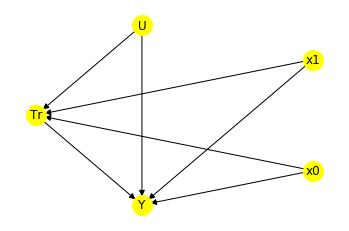

In [15]:
model, ie, dat = causalModel(**data_dict)
model.view_model()

### Methods DoWhy
1. Propensity Score Matching: ```backdoor.propensity_score_matching```
2. Propensity Score Stratification: ```backdoor.propensity_score_stratification```
3. Propensity Score-based Inverse Weighting: ```backdoor.propensity_score_weighting```
4. Linear Regression: ```backdoor.linear_regression```
1. Instrumental Variables: ```iv.instrumental_variable```

### Target Units
1. ATE: ***ate***
2. ATT: ***att***
3. ATC: ***atc***

In [16]:
methods = {1:'backdoor.propensity_score_matching',
           2:'backdoor.propensity_score_stratification',
           3:'backdoor.propensity_score_weighting'}

target_units = 'ate'

In [17]:
%%time
data_dict = {'data':df,
             'treatment_name': 'Tr',
             'outcome_name': 'Y',
             'common_causes_names': common_causes_names
            }
model, ie, dat0 = causalModel(**data_dict)

params = {'identified_estimand':ie, 'method_name': methods[1]}
estimate = model.estimate_effect(**params, target_units = target_units  )
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(Y|x0,x1))
d[Tr]                      
Estimand assumption 1, Unconfoundedness: If U→{Tr} and U→Y then P(Y|Tr,x0,x1,U) = P(Y|Tr,x0,x1)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Y~Tr+x0+x1
Target units: ate

## Estimate
Mean value: 0.17688

CPU times: user 18.4 s, sys: 62.4 ms, total: 18.5 s
Wall time: 14.7 s


In [18]:
%%time

model, ie, dat1 = causalModel(**data_dict)

params = {'identified_estimand':ie, 'method_name': methods[2] }
estimate = model.estimate_effect(**params, target_units = target_units  )
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(Y|x0,x1))
d[Tr]                      
Estimand assumption 1, Unconfoundedness: If U→{Tr} and U→Y then P(Y|Tr,x0,x1,U) = P(Y|Tr,x0,x1)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Y~Tr+x0+x1
Target units: ate

## Estimate
Mean value: 0.26468897544862263

CPU times: user 2.61 s, sys: 13.5 ms, total: 2.62 s
Wall time: 180 ms


In [19]:
%%time

model, ie, dat2 = causalModel(**data_dict)

params = {'identified_estimand':ie, 'method_name': methods[3] }
estimate = model.estimate_effect(**params, target_units = target_units, 
                                method_params = {"weighting_scheme":"ips_weight"})

ipw = dat2
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(Y|x0,x1))
d[Tr]                      
Estimand assumption 1, Unconfoundedness: If U→{Tr} and U→Y then P(Y|Tr,x0,x1,U) = P(Y|Tr,x0,x1)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Y~Tr+x0+x1
Target units: ate

## Estimate
Mean value: -0.18427899321641483

CPU times: user 817 ms, sys: 1.1 s, total: 1.92 s
Wall time: 136 ms


### EconML Models

In [20]:
%%time
from econml.metalearners import TLearner, SLearner, XLearner, DomainAdaptationLearner
from econml.drlearner import DRLearner
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split




/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


CPU times: user 685 ms, sys: 334 ms, total: 1.02 s
Wall time: 1.47 s


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [21]:
dftr, dfte = train_test_split(df.copy(), test_size = 0.2, random_state = 0)
dftr, dfte = dftr.reset_index(drop = True), dfte.reset_index(drop = True)
xn = ['x'+str(i) for i in range(n_features)]
n = len(dftr)

### T-Learner
$\begin{align}
&\mu_0 = E[Y^0|X^0]\\
&\mu_1 = E[Y^1|X^1]\\
&\tau(x) = \mu^1(x) - \mu^0(x)\\
\end{align}
$

In [22]:
# Instantiate T learner
models1 = MLWrapper(GradientBoostingClassifier(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100)))
models2 = MLWrapper(GradientBoostingClassifier(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100)))

T_learner = TLearner(models=(models1, models2))
# Train T_learner
T_learner.fit(Y = dftr.Y, T = dftr.Tr, X=dftr[xn])
# Estimate treatment effects on test data
T_te = T_learner.effect(dfte[xn])
T_tr = T_learner.effect(dftr[xn])

print('Test ATT:', T_te[dfte.Tr == 1].mean())
print('Train ATT:', T_tr[dftr.Tr == 1].mean())
print('Test ATE:',T_te.mean())
print('Train ATE:',T_tr.mean())

Test ATT: 0.42756450671739454
Train ATT: 0.41683904250897635
Test ATE: 0.16408576807040953
Train ATE: 0.16703301918746513


### S-Learner
$
\begin{align}
&\mu = E[Y|X, T]\\
&\tau = \mu(x, 1) - \mu(x, 0)\\
\end{align}
$

In [23]:
# Instantiate S learner
overall_model = MLWrapper(GradientBoostingClassifier(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100)))
overall_model = MLWrapper(LogisticRegression())

S_learner = SLearner(overall_model=overall_model)
# Train S_learner
S_learner.fit(Y = dftr.Y, T = dftr.Tr, X=dftr[xn])
# Estimate treatment effects on test data
S_te = S_learner.effect(dfte[xn])
S_tr = S_learner.effect(dftr[xn])

print('Test ATT:', S_te[dfte.Tr == 1].mean())
print('Train ATT:', S_tr[dftr.Tr == 1].mean())
print('Test ATE:',S_te.mean())
print('Train ATE:',S_tr.mean())

Test ATT: 0.3889830738670813
Train ATT: 0.38755641964825926
Test ATE: 0.18829058466575138
Train ATE: 0.19202055837360094


### X-Learner
$\begin{align}
&\mu_0 = E[Y^0|X^0]\\
&\mu_1 = E[Y^1|X^1]\\
&D^1 = Y^1 - \mu_0(X^1)\\
&D^0 =  \mu_1(X^0)-Y^0\\
&\tau_1 = E[D^1 |X^1]\\
&\tau_0 = E[D^0 |X^0]\\
&\tau_f = g(x)\tau_1(x) +(1-g(x))\tau_0(x)\\
&g(x) = P(T=1|X)
\end{align}$

In [24]:
# Instantiate X learner

models1 = MLWrapper(GradientBoostingClassifier(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100)))
models2 = MLWrapper(GradientBoostingClassifier(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100)))
#modesl1 = MLWrapper(LogisticRegression())
#modesl2 = MLWrapper(LogisticRegression())

models3 = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))#GradientBoostingClassifier(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
models4 = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
#models3 = LinearRegression()
#models4 = LinearRegression()
#models = GradientBoostingClassifier(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
propensity_model = RandomForestClassifier(n_estimators=100, max_depth=6, 
                                                  min_samples_leaf=int(n/100))
X_learner = XLearner(models = (models1,models2), 
                     cate_models=(models3, models4),
                     propensity_model=propensity_model)
# Train X_learner
X_learner.fit(Y = dftr.Y, T = dftr.Tr, X=dftr[xn])
# Estimate treatment effects on test data
X_te = X_learner.effect(dfte[xn])
X_tr = X_learner.effect(dftr[xn])


print('Test ATT:', X_te[dfte.Tr == 1].mean())
print('Train ATT:', X_tr[dftr.Tr == 1].mean())
print('Test ATE:',X_te.mean())
print('Train ATE:',X_tr.mean())

Test ATT: 0.42865842102366564
Train ATT: 0.4171825652286929
Test ATE: 0.17535088867937001
Train ATE: 0.1780140011278135


### Domain Adaptation Learner
$\begin{align}
&\mu_0 = E[Y^0|X^0],\,\,\, weights = \frac{g(x)}{1-g(x)}\\
&\mu_1 = E[Y^1|X^1],\,\,\, weights = \frac{1-g(x)}{g(x)}\\
&D^1 = Y^1 - \mu_0(X^1)\\
&D^0 =  \mu_1(X^0)-Y^0\\
&\tau_f = E[[D^1, D^0]|[X^1, X^0]]\\
&g(x) = P(T=1|X)
\end{align}$

In [25]:
# Instantiate Domain Adaptation learner
models1 = GradientBoostingClassifier(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
models2 = MLWrapper(GradientBoostingClassifier(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100)))
models3 = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))#GradientBoostingClassifier(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
models4 = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
models5 = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
models6 = LinearRegression()
#propensity_model = RandomForestClassifier(n_estimators=100, max_depth=6, 
#                                                 min_samples_leaf=int(n/100))

propensity_model = LogisticRegression()

DA_learner = DomainAdaptationLearner(models = models6,
                                     final_models = models6,
                                     propensity_model= propensity_model)

DA_learner.fit( Y = dftr.Y.values, T =  dftr.Tr.values, X=dftr[xn].values)

# Estimate treatment effects on test data
DA_te = DA_learner.effect(dfte[xn])
DA_tr = DA_learner.effect(dftr[xn])

print('Test ATT:', DA_te[dfte.Tr == 1].mean())
print('Train ATT:', DA_tr[dftr.Tr == 1].mean())
print('Test ATE:',DA_te.mean())
print('Train ATE:',DA_tr.mean())

Test ATT: 0.3611708553324667
Train ATT: 0.3604660648176024
Test ATE: 0.16656598032733083
Train ATE: 0.1694004562519155


### Doubly Robust Estimator

$\begin{align}
&Y_{i,t}^{DR} = g_t(X) + \frac{Y_i - g_t(X)}{p(T=t \,|\,X)}I\{T = t_i\} \\
&\theta_t = E[Y_t^{DR}-Y_0^{DR}|\, X]
\end{align}$

In [26]:
model1 = GradientBoostingClassifier(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
model2 = GradientBoostingClassifier(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
model1 = LinearRegression()
model2 = LogisticRegression()

model3 = LinearRegression()

DR_learner = DRLearner(model_propensity = model2, 
                          model_regression = model1,
                          model_final = model3)

DR_learner.fit( Y = dftr.Y.values, T =  dftr.Tr.values, X=dftr[xn].values)

# Estimate treatment effects on test data
DR_te = DR_learner.effect(dfte[xn])
DR_tr = DR_learner.effect(dftr[xn])

print('Test ATT:', DR_te[dfte.Tr == 1].mean())
print('Train ATT:', DR_tr[dftr.Tr == 1].mean())
print('Test ATE:',DR_te.mean())
print('Train ATE:',DR_tr.mean())

Test ATT: 0.4099799996935096
Train ATT: 0.4091279755244269
Test ATE: 0.137301449402179
Train ATE: 0.14130010385258002


### Linear DR

In [27]:
from econml.drlearner import LinearDRLearner as LDRLearner

LDR_learner = LDRLearner()

LDR_learner.fit( Y = dftr.Y.values, T =  dftr.Tr.values, X=dftr[xn].values)

# Estimate treatment effects on test data
LDR_te = LDR_learner.effect(dfte[xn])
LDR_tr = LDR_learner.effect(dftr[xn])

print('Test ATT:', LDR_te[dfte.Tr == 1].mean())
print('Train ATT:', LDR_tr[dftr.Tr == 1].mean())
print('Test ATE:',LDR_te.mean())
print('Train ATE:',LDR_tr.mean())

Test ATT: 0.42701886203123907
Train ATT: 0.42610851043177433
Test ATE: 0.26597782775870044
Train ATE: 0.268258233678445


### Sparse Linear Dr Lerner

In [28]:
from econml.drlearner import SparseLinearDRLearner as SLDRLearner

SLDR_learner = SLDRLearner()

SLDR_learner.fit( Y = dftr.Y.values, T =  dftr.Tr.values, X=dftr[xn].values)

# Estimate treatment effects on test data
SLDR_te = SLDR_learner.effect(dfte[xn])
SLDR_tr = SLDR_learner.effect(dftr[xn])

print('Test ATT:', SLDR_te[dfte.Tr == 1].mean())
print('Train ATT:', SLDR_tr[dftr.Tr == 1].mean())
print('Test ATE:',SLDR_te.mean())
print('Train ATE:',SLDR_tr.mean())

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/utilities.py:75: UserWarning: The number of features in the final model (< 5) is too small for a sparse model. We recommend using the LinearDRLearner for this low-dimensional setting.
  warn(msg, UserWarning)


Test ATT: 0.448551067291759
Train ATT: 0.4481936172089206
Test ATE: 0.222918548922525
Train ATE: 0.22629658386282045


### Forest DR Learner

In [29]:
from econml.drlearner import ForestDRLearner as FDRLearner

FDR_learner = FDRLearner(model_regression=GradientBoostingRegressor(),
                      model_propensity=GradientBoostingClassifier())

FDR_learner.fit(Y = dftr.Y.values, T =  dftr.Tr.values, X=dftr[xn].values)

FDR_te = FDR_learner.effect(dfte[xn])
FDR_tr = FDR_learner.effect(dftr[xn])

print('Test ATE:',FDR_te.mean())
print('Train ATE:',FDR_tr.mean())

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_e

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_e

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_e

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_e

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_e

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/ma

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:67: RuntimeWarning: invalid value encountered in true_divide
  value_est = num_est / weight_est
/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/econml/sklearn_extensions/ensemble.py:85: RuntimeWarning: invalid value encountered in true_divide
  impurity_est += impurity_est_i / weight_e

Test ATE: 0.16599360725370507
Train ATE: 0.16924842545473656


### Just Linear logistic (basically S learner with logistic)

In [30]:
m0, m1 = log_effect(LogisticRegression, df, xn, w = ['balanced', None])

y0 = m0.predict_proba(dfte[xn])[:,1]
y1 = m1.predict_proba(dfte[xn])[:,1]

yest = pd.DataFrame(np.concatenate((y0[:,np.newaxis], y1[:,np.newaxis]), axis = 1),
                    columns = ['Y0est', 'Y1est'])
print('ATE:{}\nATT:{}'.format(ate(dfte.Y, yest, dfte.Tr), att(dfte.Y, yest, dfte.Tr)))

ATE:0.1819550919063992
ATT:0.6488761862427552


### Custom IPW

In [31]:
propensity = LogisticRegression(class_weight = None).fit(X = df[xn].values, y = df.Tr.astype(int).values)
prop = propensity.predict_proba(df[xn])[:,1]

mask = df.Tr == 1

ateprop = 1/len(prop)*(np.sum(df[mask].Y/prop[mask]) - np.sum(df[~mask].Y/(1-prop[~mask])))
print(ateprop)

0.19379391346338906


In [32]:
import seaborn as sns

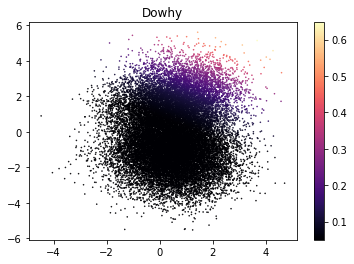

In [33]:
plt.scatter(ipw['x0'], ipw['x1'], c = ipw['ps'], cmap = 'magma', s = 0.3 )
plt.colorbar()
plt.title('Dowhy')
plt.show()


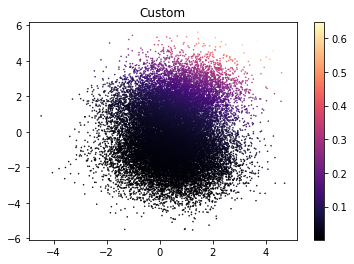

In [34]:
plt.scatter(df['x0'],df['x1'], c = prop, cmap = 'magma', s = 0.3 )
plt.colorbar()
plt.title('Custom')
plt.show()

In [35]:
true_effects

ate      0.229640
att      0.781333
ateE     0.956600
attE     0.954766
ateNE    0.047900
attNE   -0.038168
dtype: float64

### Cluster Treated

In [36]:
from sklearn.cluster import KMeans

kmean = KMeans(n_clusters = 3, random_state = 0)
kmean = kmean.fit(df.loc[df.Tr == 1, xn].values)

In [37]:
df_clust = df.copy()
clusts = kmean.predict(df_clust[xn])

In [38]:
clust_data = []
for i in np.unique(clusts):
    clust_data.append(df_clust[clusts == i].reset_index(drop = True))

In [39]:
data_dictC0 = {'data':clust_data[0],
             'treatment_name': 'Tr',
             'outcome_name': 'Y',
             'common_causes_names': common_causes_names
            }
model, ie, datC0 = causalModel(**data_dictC0)

params = {'identified_estimand':ie, 'method_name': methods[2] }
estimate = model.estimate_effect(**params, target_units = target_units  )
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(Y|x0,x1))
d[Tr]                      
Estimand assumption 1, Unconfoundedness: If U→{Tr} and U→Y then P(Y|Tr,x0,x1,U) = P(Y|Tr,x0,x1)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Y~Tr+x0+x1
Target units: ate

## Estimate
Mean value: 0.052208835341365445



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [40]:
data_dictC1 = {'data':clust_data[1],
             'treatment_name': 'Tr',
             'outcome_name': 'Y',
             'common_causes_names': common_causes_names
            }
model, ie, datC1 = causalModel(**data_dictC1)

params = {'identified_estimand':ie, 'method_name': methods[2] }
estimate = model.estimate_effect(**params, target_units = target_units  )
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(Y|x0,x1))
d[Tr]                      
Estimand assumption 1, Unconfoundedness: If U→{Tr} and U→Y then P(Y|Tr,x0,x1,U) = P(Y|Tr,x0,x1)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Y~Tr+x0+x1
Target units: ate

## Estimate
Mean value: 0.6955814643673575



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [41]:
data_dictC2 = {'data':clust_data[2],
             'treatment_name': 'Tr',
             'outcome_name': 'Y',
             'common_causes_names': common_causes_names
            }
model, ie, datC2 = causalModel(**data_dictC2)

params = {'identified_estimand':ie, 'method_name': methods[2] }
estimate = model.estimate_effect(**params, target_units = target_units  )
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(Y|x0,x1))
d[Tr]                      
Estimand assumption 1, Unconfoundedness: If U→{Tr} and U→Y then P(Y|Tr,x0,x1,U) = P(Y|Tr,x0,x1)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Y~Tr+x0+x1
Target units: ate

## Estimate
Mean value: 0.3001757971125641



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [42]:
true_effects

ate      0.229640
att      0.781333
ateE     0.956600
attE     0.954766
ateNE    0.047900
attNE   -0.038168
dtype: float64